# Trial for own CNN w/ pixel-targeting


based on Base_Model_01.ipynb
----


In [4]:
import random
import numpy as np

import json
import matplotlib.pyplot as plt
from tqdm import tqdm as tq
import matplotlib.patches as patches

import tensorflow as tf
from keras import models, layers, optimizers, losses, metrics
from keras.utils import load_img
from keras.utils import img_to_array

-------------------------
# Import data

----


## Loading the Image

In [5]:
# Data sources
path_raw_data = 'Potsdam_v02_small/'
name_raw_data = 'Potsdam02s'
raw_image_number = 0
tile_size = 50 # in pixel
batch_size = 300

## Loading the label-points for the picture from label studio

There are (1383,) labeled trees in the picture


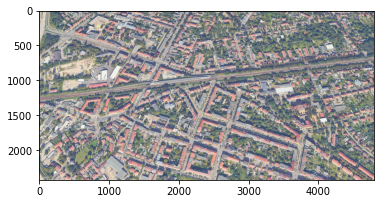

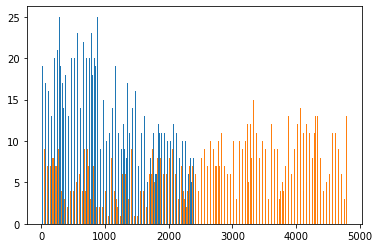

The image size is 2427x4800 pixels.
The 1383 data points are distributed along the respective axis as follows:


In [311]:
def import_image(path_raw_data, name_raw_data, raw_image_number):

    # load the image to get its shape
    orig_image = load_img(path_raw_data+name_raw_data+'.jpg')
    i_width, i_height = orig_image.size

    # convert to numpy array
    image = img_to_array(orig_image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # load the label-points for the picture from label studio
    with open(path_raw_data+name_raw_data+'.json') as json_file:
        json_load = json.load(json_file)

    # select data
    json_load = json_load[raw_image_number]["annotations"][0]["result"]
    labels_x = ([])
    labels_y = ([])
    for i in json_load:
            labels_x = np.append(labels_x, i["value"]["x"])
            labels_y = np.append(labels_y, i["value"]["y"])
    labels_unscaled = np.vstack((labels_y, labels_x)).transpose()

    # scale data points to image pixels
    reshaper = [[(i_height/100), 0], [0,(i_width/100)]]
    labels = np.mat(labels_unscaled) * np.mat(reshaper)
    print(f"There are {labels_unscaled[:,0].shape} labeled trees in the picture")

    # show image
    plt.imshow(orig_image)
    plt.show()
    plt.close()
    # check label distribution in histogram
    plt.hist(labels, bins=200)
    plt.show()
    print(f"The image size is {i_height}x{i_width} pixels.")
    print(f"The {len(labels_x)} data points are distributed along the respective axis as follows:")

    return image, labels, orig_image, labels_unscaled, i_width, i_height

image, labels, orig_image, labels_unscaled, i_width, i_height = import_image(path_raw_data, name_raw_data, raw_image_number)

Matching Image and labels and show upload result

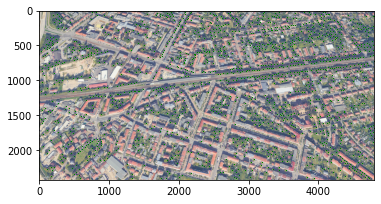

In [313]:
def show_img_with_labels(image=orig_image, labels=labels, marker=','):
    plt.imshow(image)
    # plot each labeled tree
    for dot in labels:
        #print(dot[:,1])
        plt.plot(dot[:,1], dot[:,0], marker=marker, color="green")
    # show the plot
    plt.show()

show_img_with_labels()

## Prepare tiles

Tiles = child-pictures of image, all together represent the whole image
- split the picture into quadratic tiles of equal size

In [422]:
def make_tiles(image=image, i_width=i_width, i_height=i_height, tile_size=tile_size):
    # define the tiles
    num_hor_tiles = int(np.ceil(i_width / tile_size))
    num_ver_tiles = int(np.ceil(i_height / tile_size))
    num_tiles = num_hor_tiles * num_ver_tiles
    print(f"There are {num_tiles} tiles at {tile_size}x{tile_size} pixels")
    print(f"There are {num_hor_tiles} horizontal tile columns and {num_ver_tiles} vertical tile rows")

    # prepare variables for the tiles
    image = np.array(image) # input image
    tiles = np.zeros((num_tiles, tile_size, tile_size, 3)) # all tile images
    tile_info_initial = np.zeros((num_tiles, 6)) # (tile row, tile column, true_label, probability, x_mean, y_mean)

    # create tiles
    for i in range(num_ver_tiles):
        for j in range(num_hor_tiles):
            tile_num = i * num_hor_tiles + j
            # give starting (left/top) & mean pixels in rows and columns for this tile
            v_start = i * tile_size
            h_start = j * tile_size
            v_mean = v_start + tile_size // 2
            h_mean = h_start + tile_size // 2
            # create tile
            tile = image[v_start:v_start+tile_size, h_start:h_start+tile_size, :]
            # add tile to array
            tiles[tile_num] = tile
            # store location ot tiles:
            tile_info_initial[tile_num] = (i,j,0,0,v_mean, h_mean)

    print(f"Tiles are created: {tiles.shape}.")
    return tiles, tile_info_initial, num_hor_tiles, num_ver_tiles

tiles, tile_info_initial, num_hor_tiles, num_ver_tiles = make_tiles()

There are 4704 tiles at 50x50 pixels
There are 96 horizontal tile columns and 49 vertical tile rows


ValueError: could not broadcast input array from shape (27,50,3) into shape (50,50,3)

In [417]:
2427/50

48.54

In [415]:
def label_tiles(labels=labels, tile_info_initial=tile_info_initial, tile_size=tile_size):
    num_tiles = tile_info_initial.shape[0]
    num_horizontal_tiles = tile_info_initial[:,1].max() + 1 # number of horizontal tiles
    print(num_horizontal_tiles)

    # Labeling the tiles
    tile_labels = np.zeros((num_tiles, 1)) # labels for each tile: 0 = no tree, 1 = tree
    tile_dense = np.zeros((num_tiles, 1)) # number of trees in each tile = density of a tile
    tile_info = tile_info_initial

    for label in labels:
        pos_horizontal = label[:,1] // tile_size  # tile column
        pos_vertical = label[:,0] // tile_size  # tile row

        print(pos_vertical, pos_horizontal)
        tile_num = int(pos_vertical * (num_horizontal_tiles) + pos_horizontal)
        tile_labels[tile_num] = 1
        tile_dense[tile_num] += 1
        tile_info[tile_num][2] = 1

    # print info on input labels
    print(f"Labels vector is created over all tiles: {tile_labels.shape}.")
    print(f"Tiles labeled as with tree: {tile_labels.sum()}")
    print(f"This is {tile_labels.sum()/tile_labels.shape[0]*100}% of the tiles.")
    print(f"Total trees assigned: {tile_dense.sum()}.")

    # show label distribution amongst tiles
    print(f"The max number of trees per tile is: {tile_dense.max()}")
    plt.hist(tile_dense, bins=5, color="green")
    print("Distribution trees per tile:")
    plt.show()
    plt.close()
    # check label distribution in histogram
    plt.plot(tile_info[:,2], '*')
    plt.show()

    return tile_info, tile_labels

tile_info, tile_labels = label_tiles()

96.0
[[5.]] [[13.]]
[[7.]] [[2.]]
[[8.]] [[4.]]
[[5.]] [[7.]]
[[5.]] [[5.]]
[[5.]] [[6.]]
[[3.]] [[5.]]
[[3.]] [[5.]]
[[2.]] [[6.]]
[[1.]] [[5.]]
[[1.]] [[5.]]
[[1.]] [[3.]]
[[0.]] [[4.]]
[[3.]] [[4.]]
[[3.]] [[6.]]
[[3.]] [[8.]]
[[0.]] [[16.]]
[[0.]] [[15.]]
[[2.]] [[14.]]
[[1.]] [[16.]]
[[0.]] [[6.]]
[[2.]] [[4.]]
[[6.]] [[19.]]
[[6.]] [[18.]]
[[4.]] [[18.]]
[[2.]] [[20.]]
[[1.]] [[18.]]
[[4.]] [[27.]]
[[4.]] [[28.]]
[[4.]] [[28.]]
[[4.]] [[29.]]
[[3.]] [[29.]]
[[5.]] [[30.]]
[[7.]] [[30.]]
[[6.]] [[32.]]
[[6.]] [[33.]]
[[6.]] [[33.]]
[[4.]] [[33.]]
[[1.]] [[33.]]
[[1.]] [[33.]]
[[6.]] [[24.]]
[[6.]] [[25.]]
[[5.]] [[26.]]
[[6.]] [[28.]]
[[8.]] [[25.]]
[[8.]] [[21.]]
[[5.]] [[22.]]
[[7.]] [[30.]]
[[1.]] [[36.]]
[[1.]] [[38.]]
[[7.]] [[37.]]
[[6.]] [[38.]]
[[5.]] [[38.]]
[[5.]] [[39.]]
[[4.]] [[39.]]
[[4.]] [[39.]]
[[3.]] [[40.]]
[[3.]] [[40.]]
[[2.]] [[41.]]
[[1.]] [[41.]]
[[0.]] [[41.]]
[[0.]] [[43.]]
[[1.]] [[43.]]
[[1.]] [[42.]]
[[3.]] [[41.]]
[[5.]] [[40.]]
[[5.]] [[44.]]
[[7.]] 

IndexError: index 4702 is out of bounds for axis 0 with size 4608

In [409]:
1//50

0

In [399]:
example =
y = labels[example,0]
x = labels[example,1]
print(f"Pixel == ver: {y}, hor: {x}")

pos_horizontal = labels[example,0] // tile_size

pos_horizontal

Pixel == ver: 275.27079330662025, hor: 671.0891169092579


5.0

The shape of the tiled picture is (48, 96)
1406.0 tiles are labeled as trees.


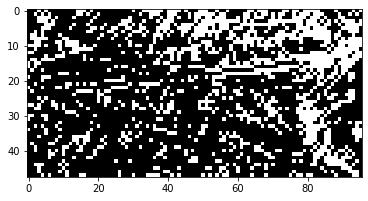

In [393]:
def show_true_tiles(tile_info=tile_info):
    # show labeled tiles
    num_ver = int(tile_info[:,0].max()) + 1
    num_hor = int(tile_info[:,1].max()) + 1
    tiles_show = tile_info[:,2].reshape(num_ver, num_hor)
    print(f"The shape of the tiled picture is {tiles_show.shape}")
    print(f"{tile_info[:,2].sum()} tiles are labeled as trees.")
    plt.imshow(tiles_show, cmap='gray')

show_true_tiles()

target mean pixel is at 775.0, 4225.0
Tile: 1524
Column: 84.0, Row: 15.0
The partial image represents pixels (hor) 4150:4300 x (ver) 700:850 of the image
Tile label: 1.0
Tile prediction: 0.0


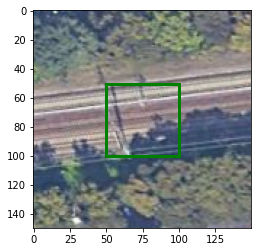

In [394]:
# show image frame around target tile
def show_target_tile(target=None, image=image, tile_info=tile_info, tile_size=tile_size):

    # choose target tile
    example = random.randint(0, len(tile_info)-1)
    if target is None: target = example
    else: target = target

    # prepare variables
    print(f"target mean pixel is at {tile_info[target,4]}, {tile_info[target,5]}")
    v_min = int(np.array([tile_info[target,4] - 1.5 * tile_size]))
    v_max = int(v_min + 3 * tile_size)
    h_min = int(np.array([tile_info[target,5] - 1.5 * tile_size]))
    h_max = int(h_min + 3 * tile_size)
    h_frame = tile_size # starting pixel of frame
    v_frame = tile_size

    # adjust for image borders
    if v_min < 0:
        v_min = 0
        v_frame = 0
    if h_min < 0:
        h_min = 0
        h_frame = 0
    if h_max > image.shape[1]:
        h_max = image.shape[1]
    if v_max > image.shape[0]:
        v_max = image.shape[0]

    # print info
    print(f"Tile: {target}")
    print(f"Column: {tile_info[target,1]}, Row: {tile_info[target,0]}")
    print(f"The partial image represents pixels (hor) {h_min}:{h_max} x (ver) {v_min}:{v_max} of the image")
    print(f"Tile label: {tile_info[target,2]}")
    print(f"Tile prediction: {tile_info[target,3]}")

    # show image and frame around target tile
    image_partial = image[v_min:v_max, h_min:h_max, :]
    if tile_info[target,2] == 1: color = "green"
    else : color = "red"
    rect = patches.Rectangle((h_frame, v_frame), tile_size, tile_size, linewidth=3, edgecolor=color, facecolor='none')

    plt.imshow(image_partial)
    ax = plt.gca()
    ax.add_patch(rect)
    plt.show()
    plt.close()
    pass

show_target_tile(1620-1*96)

## Prepare training and validation set

In [ ]:
def make_train_set(tiles=tiles, tile_labels=tile_labels, tile_size=tile_size, batch_size=batch_size):
    # define the training set
    train_ratio = 0.8
    num_tiles = tiles.shape[0]
    num_train_tiles = int(num_tiles * train_ratio)
    num_val_tiles = num_tiles - num_train_tiles
    print(f"There are {num_tiles} tiles in total.")
    print(f"There are {num_train_tiles} tiles in the training set.")
    print(f"There are {num_val_tiles} tiles in the validation set.")

    # split into training and validation set
    train_tiles = tiles[:int(num_tiles*train_ratio)]
    train_labels = tile_labels[:int(num_tiles*train_ratio)]
    val_tiles = tiles[int(num_tiles*train_ratio):]
    val_labels = tile_labels[int(num_tiles*train_ratio):]
    print(f"Training set: {train_tiles.shape} - ({train_ratio} share of all tiles)")
    print(f"Validation set: {val_tiles.shape}")

    # build tensorflow dataset
    dataset_train_original = tf.data.Dataset.from_tensor_slices((train_tiles, train_labels))
    dataset_validate_original = tf.data.Dataset.from_tensor_slices((val_tiles, val_labels))

    # shuffle and batch
    def encode(tile, label):
        image_encoded = tf.image.convert_image_dtype(tile, dtype=tf.float32)
        image_encoded = tf.image.resize(image_encoded, (tile_size, tile_size))
        return image_encoded, label

    dataset_train = dataset_train_original.map(lambda image, label: encode(image, label)).cache().shuffle(25).batch(batch_size)
    dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label)).cache().batch(batch_size)

    return dataset_train, dataset_validate

dataset_train, dataset_validate = make_train_set()

-------
# Training

----



## model


In [ ]:
def make_model_base(tile_size=tile_size):

    METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
    initializer = tf.keras.initializers.GlorotUniform(seed=42)

    model = models.Sequential()

    model.add(layers.Input(shape=(tile_size, tile_size, 3)))
    model.add(layers.Conv2D(20, (3,3), activation="relu", padding="same"))
    model.add(layers.Conv2D(30, (3,3), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(150, activation="relu"))
    model.add(layers.Dense(20, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid", kernel_initializer=initializer))
    model.summary()

    model.compile(
        loss='binary_crossentropy',
        optimizer="adam",
        metrics=METRICS,
        )
    return model, METRICS

model, METRICS = make_model_base()

## Train a model

In [ ]:
def train_model(model_name="latest", model=model, dataset_train=dataset_train, dataset_validate=dataset_validate, epochs=10):

    history = model.fit(
        dataset_train,
        epochs=epochs,
        validation_data=dataset_validate,
    )
    model.save(model_name)
    return model, history, model_name

model, history, model_name = train_model(model_name="model_base")

In [ ]:
def render_history(history=history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["precision"], label="precision")
    plt.plot(history["val_precision"], label="val_precision")
    plt.legend()
    plt.title("Our precision")
    plt.show()
    plt.close()
    pass

def compare_histories(history_list=history_list):
    for training_name, history in history_list.items():
        plt.plot(history["val_binary_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_accuracy")
    plt.show()
    plt.close()
    pass

In [ ]:
render_history(history.history)

In [ ]:
history_list[model_name] = history.history
compare_histories()
tf.keras.backend.clear_session()

-------------------------
# Predict

-----

## predict on training data

In [ ]:
# predict
threshold = 0.3
probabilities = model.predict(tiles)
predictions = [1 if x >= threshold else 0 for x in probabilities]
predictions = np.array(predictions)
# The tiles_info stores: vertical_index, horizontal_index, true label, probability, hor_mean, ver_mean
tile_info[:,3] = probabilities[:,0]

In [ ]:
# save predictions
np.savetxt(f'prediction_{name_raw_data}_{model_name}.txt', predictions)

In [ ]:
def perf_measure(y_actual=tile_info[:,2], y_hat=predictions):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

TP, FP, TN, FN = perf_measure()
print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")

In [ ]:
(METRICS) = model.evaluate(tiles, tile_labels, verbose=1)
METRICS

In [ ]:
def show_pred_tiles(predictions=predictions, tile_info=tile_info):
    # show prediction of tiles
    num_ver = int(tile_info[:,0].max()) + 1
    num_hor = int(tile_info[:,1].max()) + 1
    tiles_show = predictions.reshape(num_ver, num_hor)
    plt.imshow(tiles_show, cmap='gray')
    pass

show_pred_tiles()

In [ ]:
def show_img_with_pred(tile_info=tile_info, threshold=threshold, image=orig_image):
    plt.imshow(image)
    pred_pixels = [] # list of pixels of identified trees
    for tree in tile_info:
        if tree[3] >= threshold:
            plt.scatter(tree[5], tree[4], marker='+',  c="green")
            pred_pixels.append((tree[5], tree[4]))
    print(f"{len(pred_pixels)} trees identified")
    plt.show()
    plt.close()
    return pred_pixels

pred_pixels = show_img_with_pred()

Save predictions


## Test on images

In [ ]:
# load the image to get its shape
name_raw_data = "Potsdam_02"
orig_image = load_img(path_raw_data+name_raw_data+'.jpg')
i_width, i_height = orig_image.size
# convert to numpy array
image = img_to_array(orig_image)
# scale pixel values to [0, 1]
image = image.astype('float32')
image /= 255.0

In [ ]:
# define the tile size

num_horizontal_tiles = i_width // tile_size
num_vertical_tiles = i_height // tile_size
num_tiles = num_horizontal_tiles * num_vertical_tiles
print(f"There are {num_tiles} tiles at {tile_size}x{tile_size} pixels")
print(f"There are {num_horizontal_tiles} horizontal tile columns and {num_vertical_tiles} vertical tile rows")

# prepare variables for the tiles
image = np.array(image) # input image
tiles = np.zeros((num_tiles, tile_size, tile_size, 3)) # all tile images
tile = np.zeros((tile_size, tile_size, 3)) # image of tile
tile_info = np.zeros((num_tiles, 6)) # (tile row, tile column, true_label, probability, x_mean, y_mean)

# create tiles
for i in tq(range(num_vertical_tiles)):
    for j in range(num_horizontal_tiles):
        tile_num = i * num_horizontal_tiles + j
        # give starting (left/top) & mean pixels in rows and columns for this tile
        v_start = i * tile_size
        h_start = j * tile_size
        v_mean = v_start + tile_size // 2
        h_mean = h_start + tile_size // 2
        # create tile
        tile = image[v_start:v_start+tile_size, h_start:h_start+tile_size, :]
        # add tile to array
        tiles[tile_num] = tile
        # store location ot tiles:
        tile_info[tile_num] = (i,j,0,0,v_mean, h_mean)

print(f"Tiles are created: {tiles.shape}.")

In [ ]:
# predict
threshold = 0.3
probabilities = model.predict(tiles)
predictions = [1 if x >= threshold else 0 for x in probabilities]
predictions = np.array(predictions)
# The tiles_info stores: vertical_index, horizontal_index, true label, probability, hor_mean, ver_mean
tile_info[:,3] = probabilities[:,0]
#count true predictions
true_predictions = sum(1 if x == y else 0 for x, y in zip(predictions, tile_labels))
#true_predictions_count = sum(true_predictions)
#print(f"True trees: {tile_count.sum()}")
#print(f"Predictions: {true_predictions_count} out of {len(predictions)} tiles are identified as with trees.")
# show labeled tiles
tiles_show = predictions.reshape(num_vertical_tiles, num_horizontal_tiles)
tiles_show[tiles_show == 0] = 0
tiles_show[tiles_show > 0] = 1
plt.imshow(tiles_show)

In [ ]:
plt.imshow(orig_image)